In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.neighbors import NearestNeighbors
from minisom import MiniSom
import numpy as np
import pandas as pd

In [2]:
df = pd.read_csv('./data/merged.csv')
df.drop('Index', axis=1, inplace=True)
df.head()

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,...,190,191,192,193,194,195,196,197,198,199
0,0.029291,0.122669,0.078690,0.509404,0.257012,0.000000,0.0,0.0,0.0,0.0,...,-0.068914,0.165855,-0.139714,0.018813,0.186408,0.246452,0.127322,0.037057,0.035583,-0.192175
1,0.072681,0.114266,0.434530,0.297216,0.072028,0.000000,0.0,0.0,0.0,0.0,...,0.164396,-0.031148,-0.016781,-0.069668,0.120217,0.086646,0.081417,-0.013408,-0.056917,-0.052905
2,0.532546,0.181123,0.050537,0.051361,0.069668,0.113055,0.0,0.0,0.0,0.0,...,-0.125470,0.051412,0.059226,-0.057874,0.426521,-0.072455,0.080208,0.068673,-0.240681,-0.269405
3,0.269257,0.163069,0.563442,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.310030,-0.218989,-0.077160,-0.038774,0.162210,-0.052915,0.167200,0.059254,0.039290,0.134820
4,0.045626,0.066652,0.133848,0.193264,0.556775,0.000000,0.0,0.0,0.0,0.0,...,0.268552,0.212245,0.184841,0.022134,0.108727,-0.105548,0.056528,0.068675,0.005168,0.110122


In [3]:
# Convert Nan values to 0 in each column
df = df.fillna(0)
# Check if there are any Nan values left
df.isnull().sum()

topic_0    0
topic_1    0
topic_2    0
topic_3    0
topic_4    0
          ..
195        0
196        0
197        0
198        0
199        0
Length: 220, dtype: int64

In [4]:
def get_user_input():
    doc_index = int(input("Enter the document index (0 to 17999): "))
    num_neighbors = int(input("Enter the number of neighbors: "))
    return doc_index, num_neighbors

In [5]:
def fit_knn_model(features):
    knn = NearestNeighbors(n_neighbors=features.shape[0])  # Use maximum number of neighbors
    knn.fit(features)
    return knn

In [6]:
def get_nearest_neighbors(knn, features, doc_index, num_neighbors):
    distances, indices = knn.kneighbors(features.iloc[doc_index].values.reshape(1, -1), n_neighbors=num_neighbors + 1)
    # Exclude the first neighbor as it is the document itself
    return indices.flatten()[1:], distances.flatten()[1:]

In [7]:
 knn_model = fit_knn_model(df)
# Get user input
doc_index, num_neighbors = get_user_input()
    
# Get nearest neighbors
neighbor_indices, neighbor_distances = get_nearest_neighbors(knn_model, df, doc_index, num_neighbors)
    
# Retrieve the nearest neighbors from the original DataFrame
neighbors_df = df.iloc[neighbor_indices].copy()
neighbors_df['Distance'] = neighbor_distances
neighbors_df.head()
neighbors_df.shape

/opt/homebrew/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


(100, 221)

In [8]:
k = 3
som_shape = (1,k)

# Extract features for SOM training (excluding 'Distance' column)
features_for_som = neighbors_df.drop(columns=['Distance']).values

# Initialize and train SOM
som = MiniSom(som_shape[0], som_shape[1], features_for_som.shape[1], sigma=.5, learning_rate=.5,
              neighborhood_function='gaussian', random_seed=10)
som.train_batch(features_for_som, 1000, verbose=True)

# Assign each data point to a cluster
win_map = som.win_map(features_for_som)
cluster_index = np.zeros(features_for_som.shape[0], dtype=int)

for i, x in enumerate(features_for_som):
    w = som.winner(x)
    cluster_index[i] = w[1]  # since som_shape is (1, k), we use the second index

# Display cluster assignment for each data point
neighbors_df['cluster'] = cluster_index
#neighbors_df = neighbors_df.drop(columns=['Distance'])
neighbors_df.head()
neighbors_df.shape

 [ 1000 / 1000 ] 100% - 0:00:00 left 
 quantization error: 0.7307093734750949


(100, 222)

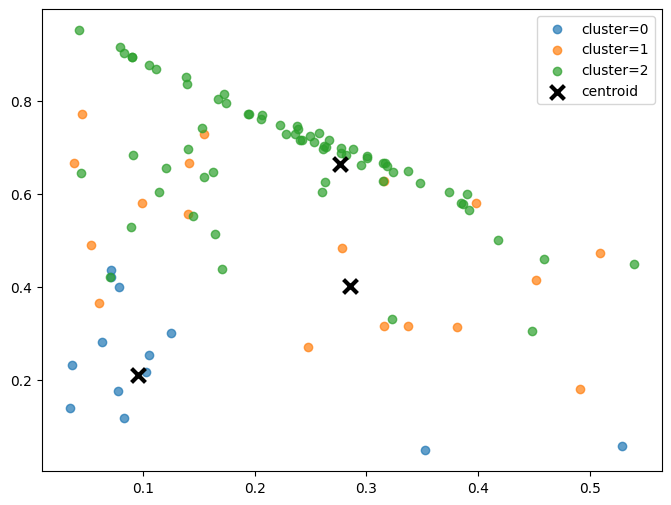

In [9]:
plt.figure(figsize=(8, 6))
for c in np.unique(cluster_index):
    plt.scatter(features_for_som[cluster_index == c, 0],
                features_for_som[cluster_index == c, 1], label='cluster=' + str(c), alpha=.7)

# Plotting centroids
centroids = som.get_weights().reshape(-1, features_for_som.shape[1])
plt.scatter(centroids[:, 0], centroids[:, 1], marker='x',
            s=100, linewidths=3, color='k', label='centroid')
plt.legend()
plt.show()


## Cluster Evalution

In [10]:
empty_clusters = [c for c in range(k) if np.sum(cluster_index == c) == 0]
print(f"Empty clusters: {empty_clusters}")

if len(empty_clusters) == 0:  # Compute only if there are no empty clusters
    silhouette_avg = silhouette_score(features_for_som, cluster_index)
    print(f"Silhouette Coefficient: {silhouette_avg}")
else:
    print("Cannot compute silhouette score due to empty clusters.")

Empty clusters: []
Silhouette Coefficient: 0.12730357482612442


In [11]:
if len(empty_clusters) == 0:  # Compute only if there are no empty clusters
    ch_score = calinski_harabasz_score(features_for_som, cluster_index)
    print(f"Calinski-Harabasz Index: {ch_score}")
else:
    print("Cannot compute Calinski-Harabasz Index due to empty clusters.")

Calinski-Harabasz Index: 7.976926611620478


In [55]:
# put all the columns of the neighbors_df in the X variable except the cluster column
features = neighbors_df.drop(columns=['cluster','Distance'])
cluster_labels = neighbors_df['cluster'] 


In [56]:
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Split the data into training and test sets
X_Train, X_Test, Y_Train, Y_Test = train_test_split(features, cluster_labels, test_size=0.2, random_state=42)

# Train the classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_Train, Y_Train)
random_forest_preds = clf.predict(X_Test)
print('The accuracy of the Random Forests model is :\t',metrics.accuracy_score(random_forest_preds,Y_Test))

The accuracy of the Random Forests model is :	 0.95


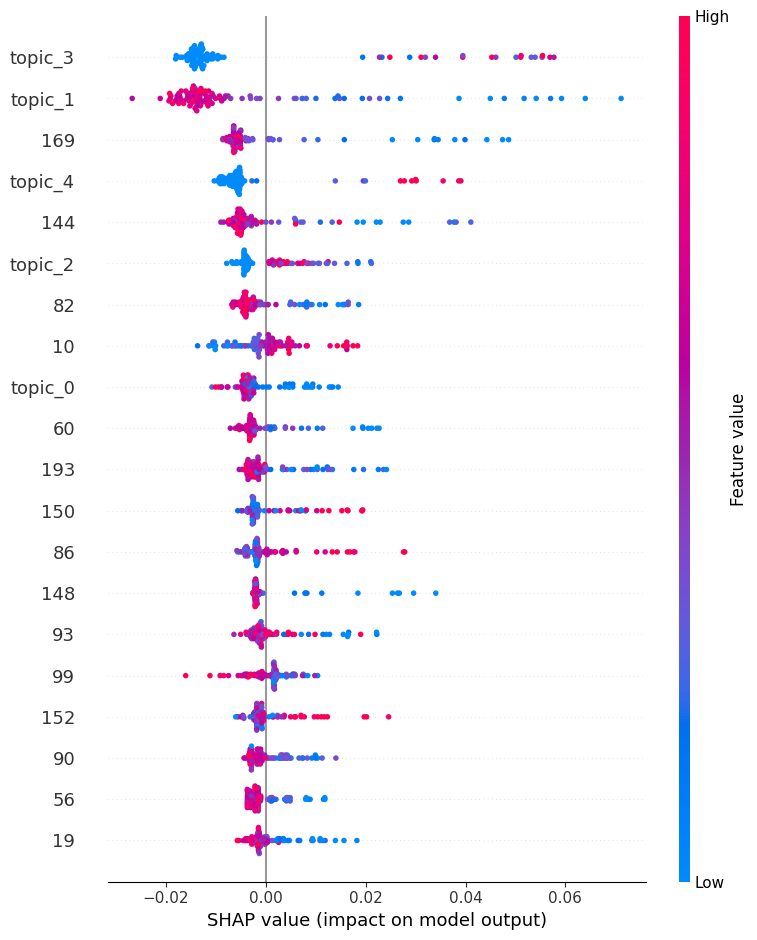

In [70]:
import shap

explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(features)
shap_values.shape

shap_values_ = shap_values.transpose((2,0,1))
# 
shap_values_[0].shape
shap.summary_plot(shap_values_[0], features)

# Similarly plot for other clusters